# Classifying different movements from just one EMG
* Pull a single set of EMG readings from a file. In this case, the columns are signal, movement and the rows are a reading every millisecond.
* Then, group the readings by their type of movement.
* For each new group, get its meaningful statistics and use those for our independent variables.
* In essence instead of just the voltage readings of the EMG as one independent variable, we can group them together by type of movement and use their meaningful statistics as our independent variables instead.
* **IMPORTANT**: make sure the UCI data (ask me if you don't know what it is) is in the same directory as where you download this notebook
* by lucas chen lucasch@umich.edu

## Imports

In [14]:
def warn(*args, **kwargs): #ignore sklearn annoying warnings
    pass
import warnings
warnings.warn = warn


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

## Preprocessing I
* Let's define some functions that lets us process the data into something that looks like what we get from the arm

In [25]:
files = ['EMG_data_for_gestures-master/01/1_raw_data_13-12_22.03.16.txt',
         'EMG_data_for_gestures-master/01/2_raw_data_13-13_22.03.16.txt',
         'EMG_data_for_gestures-master/02/1_raw_data_14-19_22.03.16.txt',
         'EMG_data_for_gestures-master/02/2_raw_data_14-21_22.03.16.txt',
         'EMG_data_for_gestures-master/03/1_raw_data_09-32_11.04.16.txt',
         'EMG_data_for_gestures-master/03/2_raw_data_09-34_11.04.16.txt']

#conglomerates the data into one dataframe.
def pull_data(files):
    df = pd.DataFrame()
    for file in files:
        f = open(file, 'r')
        f = f.readlines()
        for count, val in enumerate(f):
            row = val.split("\t")
            row[-1] = row[-1][:-1]
            f[count] = row
        df = pd.concat([df, pd.DataFrame(f[1:], columns=f[0])])
    return df.astype(float)

#narrows the dataframe to just the one channel you want to use. Then scales and removes trash values (where class is 0)
def preprocess(df, channel):
    X = df[channel]
    scaler = StandardScaler()
    X[channel] = scaler.fit_transform(X[channel].values) #try with and without scaling
    y = df[['class']]
    sample = pd.concat([X, y], axis=1)
    sample = sample[sample['class'] != 0.0] #if features are floats, change to 0.0 instead of '0' and vice versa
    return sample

* Now let's make df which is just all of the files combined into a single dataframe.
* For each (8) EMG channel we've got, let's see what they look like.
    * So it's kind of awkward to read, but the bottom graph shows the movement the patient is doing (refer to the UCI data readme if you want to know specifically which movements they are) and then every graph above shows the EMG readings for those movements.

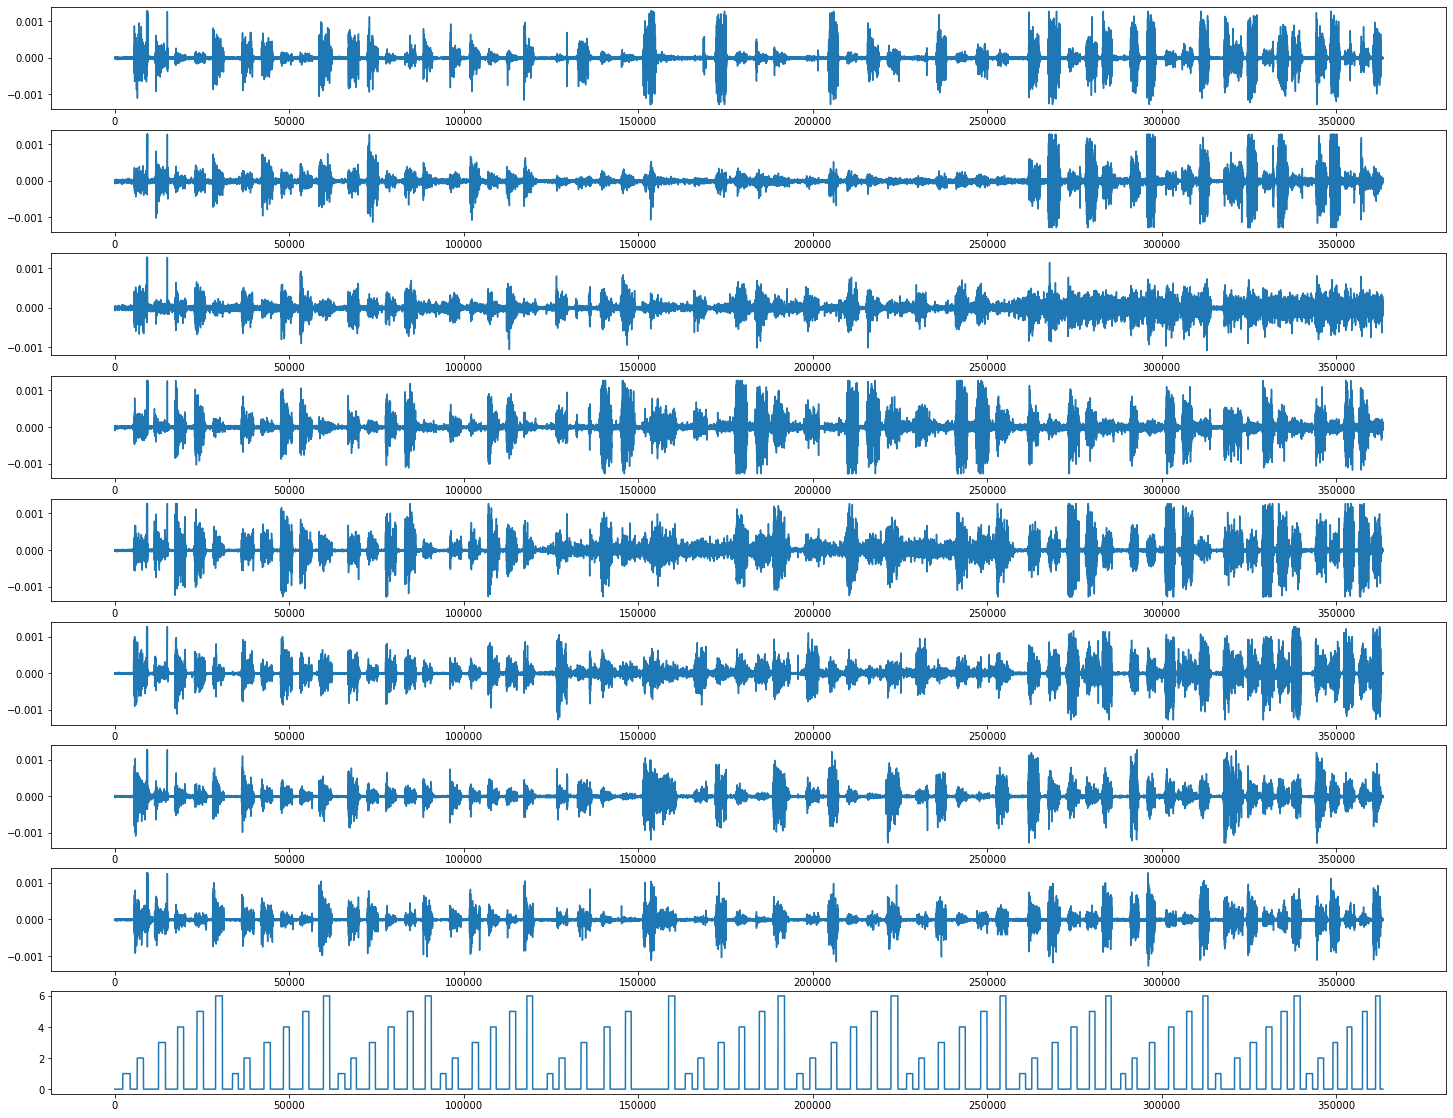

In [24]:
df = pull_data(files)

fig, axs = plt.subplots(9,figsize=(25,20))
for i in range(1, 9):
    axs[i-1].plot(df[[f'channel{i}']].values)
axs[8].plot(df[['class']].values)

In [18]:
processed_df = preprocess(df, ['channel4'])
processed_df

,channel4,class
2287,0.045593,1.0
2288,-0.002008,1.0
2289,-0.002008,1.0
2290,-0.002008,1.0
2291,-0.002008,1.0
...,...,...
48390,-0.335214,6.0
48391,-0.335214,6.0
48392,-0.335214,6.0
48393,-0.335214,6.0


* So now we're left with a sad dataframe with just one channel, its readings plus its associated class.
* This reflects the data we're going to get from the actual arm, so if you're going to read one of these bullets this is the one.
* Let's see what these readings look like for the 6 different movements. **Again the bottom graph is the class but it's in a line graph for some reason.**

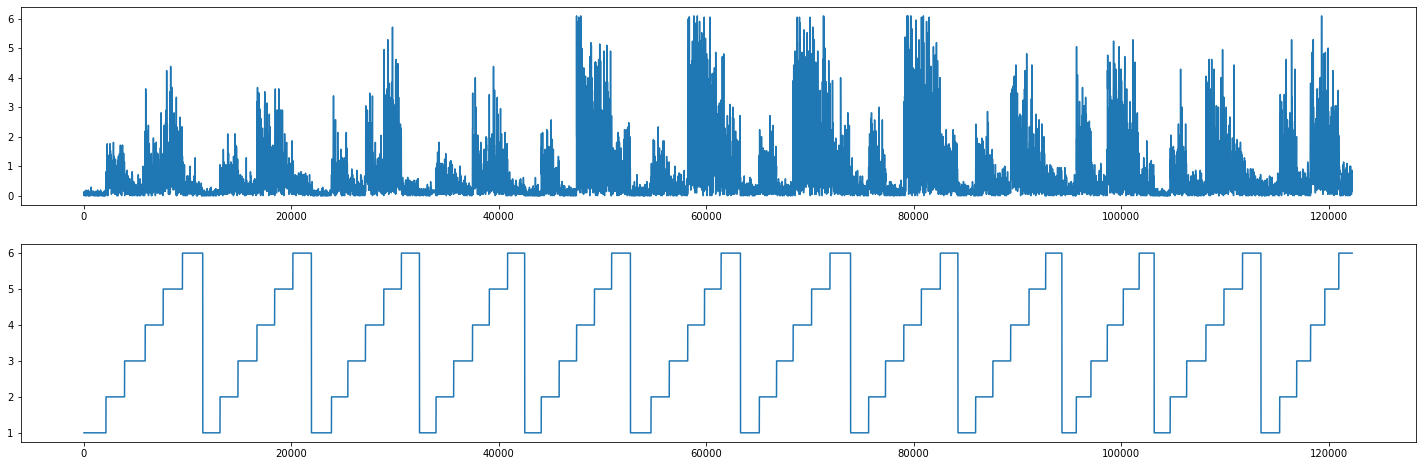

In [27]:
fig, axs = plt.subplots(2,figsize=(25,8))
readings = processed_df['channel4'].abs()

axs[0].plot(readings.values)
axs[1].plot(processed_df['class'].values)

## Preprocessing II
* this part of preprocessing is the most important. We take the sad processed data and turn it into something more usable.
* Let's make a function that does that. **Warning: This function will take a while to run because I write the least efficient functions possible!!!**

In [30]:
def get_features(df):
    new_df = pd.DataFrame(columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'class'])
    data = pd.Series(dtype='float64')
    cur_class = df['class'].iloc[0]
    for index, row in df.iterrows():
        if row['class'] != cur_class:
            to_add = pd.concat([data.describe(), pd.Series([cur_class],index=['class'])])
            new_df = new_df.append(to_add, ignore_index=True)
            data = pd.Series(dtype='float64')
            cur_class = row['class']
        data = data.append(pd.Series(row['channel4']))
    to_add = pd.concat([data.describe(), pd.Series([row['class']],index=['class'])])
    new_df = new_df.append(to_add, ignore_index=True)
    return new_df

In [31]:
sample = get_features(processed_df) #don't run again if you don't need to
sample

,count,mean,std,min,25%,50%,75%,max,class
0,2115.0,-0.000658,0.084084,-0.287613,-0.049609,-0.002008,0.045593,0.188395,1.0
1,1794.0,-0.007050,0.789840,-1.715638,-0.478017,-0.049609,0.616802,1.806823,2.0
2,1988.0,0.020379,0.304266,-0.858823,-0.192412,-0.002008,0.188395,0.997609,3.0
3,1735.0,-0.027386,1.012486,-3.619671,-0.620819,0.093193,0.664403,2.187630,4.0
4,1858.0,-0.053683,1.392043,-4.381284,-1.001626,-0.240012,0.997609,4.234465,5.0
...,...,...,...,...,...,...,...,...,...
67,1640.0,0.162215,1.330042,-4.619288,-0.597019,0.283597,0.997609,5.281683,2.0
68,1339.0,0.015589,0.405208,-1.001626,-0.240012,-0.002008,0.283597,1.140411,3.0
69,1372.0,0.089134,2.243868,-5.285700,-1.430033,0.378798,1.664021,6.090897,4.0
70,1350.0,0.021898,1.615577,-5.000095,-1.192029,-0.192412,1.045210,4.853276,5.0


* We now use its statistics as a bunch of new sets of data a model can use to classify a class.
    * We will not use these simple statistics probably, but it's the concept that is 
* So the 100k rows turned into 72. To understand what happened: In the original study where the original data came from,
    the subjects did each movement for three seconds twice. 1,2,3,4,5,6,1,2,3,4,5,6. For each of those 3 second movements, I ran .describe() to get its mean, stdev, min, etc.
    * Since I originally inputted 6 files and every subject did the movement twice per file, there should be 12 entries for the .describe() times 6 total movements. So 72.
* It's not a ton of data, but we can run a model. Let's just to KNN because I had that copy pasted in my imports.

In [34]:
from sklearn.model_selection import train_test_split

xcols = ['mean', 'std', 'min', '25%', '50%', '75%','max']

sample = sample[sample['class'].isin([1.0,2.0,4.0])]

sampleX = sample[xcols]
sampley = sample[['class']]

X_train, X_test, y_train, y_test = train_test_split(
    sampleX, sampley, test_size=0.3, stratify=sample[['class']])

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train.values, y_train.values)

knn_model.score(X_test,y_test)

1.0

* I narrow the sample down to three classes because this will definitely not work with 6.
* Then I train the model on 70% of the data and leave the remaining 30% to test and see how accurate the model is.

In [35]:
y_pred = knn_model.predict(X_test.values)
y_true = y_test.values

print(precision_score(y_true, y_pred, average='weighted'))

print(cohen_kappa_score(y_true, y_pred))

print(roc_auc_score(y_true, knn_model.predict_proba(X_test.values), multi_class='ovr'))

1.0
1.0
1.0


* These metrics measure precision, but with such a small sample it's not very believable. You could just re-run the model a bunch and average those scores I guess.

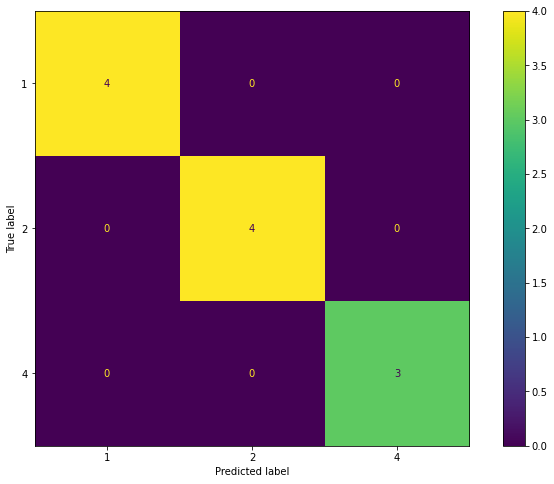

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_true, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=[1,2,4])
cmp.plot(ax=ax)

plt.show()

* So this basically just shows our test data, and if the model accurately matches it to what class it is and if it doesn,'t which one it thought it was.